# Integrate resources to create a drug repurposing hetnet

In [1]:
import pandas
import seaborn

import hetio.hetnet
import hetio.readwrite
import hetio.stats

from utils import rawgit, obo_iri

## Define the metagraph and instantiate the graph

In [2]:
kind_to_abbev = {
    
    # metanodes
    'Compound': 'C',
    'Disease': 'D',
    'Gene': 'G',
    'Anatomy': 'A',
    'Symptom': 'S',
    'Side Effect': 'SE',
    'Pathway': 'PW',
    'Perturbation': 'PB',
    'Biological Process': 'BP',
    'Cellular Component': 'CC',
    'Molecular Function': 'MF',
    
    # metaedges
    'treats': 't',
    'palliates': 'p',
    'binds': 'b',
    'expresses': 'e',
    'regulates': 'r',
    'upregulates': 'u',
    'downregulates': 'd',
    'interacts': 'i',
    'covaries': 'c',
    'regulates': 'r',
    'participates': 'p',
    'resembles': 'r',
    'associates': 'a',
    'localizes': 'l',
    'presents': 'p',
    'causes': 'c',
}

metaedge_tuples = [
    ('Compound', 'Disease', 'treats', 'both'),
    ('Compound', 'Disease', 'palliates', 'both'),
    ('Compound', 'Gene', 'binds', 'both'),
    ('Compound', 'Gene', 'upregulates', 'both'),
    ('Compound', 'Gene', 'downregulates', 'both'),
    ('Compound', 'Compound', 'resembles', 'both'),
    ('Compound', 'Side Effect', 'causes', 'both'),
    ('Anatomy', 'Gene', 'expresses', 'both'),
    ('Anatomy', 'Gene', 'upregulates', 'both'),
    ('Anatomy', 'Gene', 'downregulates', 'both'),
    ('Gene', 'Gene', 'interacts', 'both'),
    ('Gene', 'Gene', 'covaries', 'both'),
    ('Gene', 'Gene', 'regulates', 'forward'),
    ('Gene', 'Pathway', 'participates', 'both'),
    ('Perturbation', 'Gene', 'regulates', 'both'),
    ('Gene', 'Biological Process', 'participates', 'both'),
    ('Gene', 'Cellular Component', 'participates', 'both'),
    ('Gene', 'Molecular Function', 'participates', 'both'),
    ('Disease', 'Disease', 'resembles', 'both'),
    ('Disease', 'Gene', 'associates', 'both'),
    ('Disease', 'Gene', 'upregulates', 'both'),
    ('Disease', 'Gene', 'downregulates', 'both'),
    ('Disease', 'Anatomy', 'localizes', 'both'),
    ('Disease', 'Symptom', 'presents', 'both'),
]
metagraph = hetio.hetnet.MetaGraph.from_edge_tuples(metaedge_tuples, kind_to_abbev)
graph = hetio.hetnet.Graph(metagraph)

## Gene Nodes

In [3]:
commit = 'a7362748a34211e5df6f2d185bb3246279760546'
url = rawgit('dhimmel', 'entrez-gene', commit, 'data/genes-human.tsv')
gene_df = pandas.read_table(url)
gene_df = gene_df[gene_df.type_of_gene == 'protein-coding']
coding_genes = set(gene_df.GeneID)
gene_df.head(2)

,tax_id,GeneID,Symbol,chromosome,map_location,type_of_gene,description
0,9606,1,A1BG,19,19q13.4,protein-coding,alpha-1-B glycoprotein
1,9606,2,A2M,12,12p13.31,protein-coding,alpha-2-macroglobulin


In [4]:
for i, row in gene_df.iterrows():
    if row.type_of_gene != 'protein-coding':
        continue
    data = {
        'description': row['description'],
        'source': 'Entrez Gene',
        'url': 'http://identifiers.org/ncbigene/{}'.format(row.GeneID),
        'license': 'CC0 1.0',
    }
    if pandas.notnull(row['chromosome']):
        data['chromosome'] = row['chromosome']
    graph.add_node(kind = 'Gene', identifier=row.GeneID, name=row.Symbol, data=data)

## Disease Nodes

In [5]:
commit = '72614ade9f1cc5a5317b8f6836e1e464b31d5587'
url = rawgit('dhimmel', 'disease-ontology', commit, 'data/slim-terms.tsv')
disease_df = pandas.read_table(url)
disease_df.head(2)

,doid,name,source,pathophysiology
0,DOID:2531,Hematologic cancer,DOcancerslim,neoplastic
1,DOID:1319,Brain cancer,DOcancerslim,neoplastic


In [6]:
for i, row in disease_df.iterrows():
    data = {
        'source': 'Disease Ontology',
        'url': obo_iri(row.doid),
        'license': 'CC BY 3.0',
    }
    graph.add_node(kind='Disease', identifier=row.doid, name=row['name'], data=data)

## Compound Nodes

In [7]:
commit = '3e87872db5fca5ac427ce27464ab945c0ceb4ec6'
url = rawgit('dhimmel', 'drugbank', commit, 'data/drugbank-slim.tsv')
compound_df = pandas.read_table(url)
compound_df.head(2)

,drugbank_id,name,type,groups,atc_codes,categories,inchikey,inchi
0,DB00014,Goserelin,small molecule,approved,L02AE03,NaN,InChIKey=BLCLNMBMMGCOAS-URPVMXJPSA-N,InChI=1S/C59H84N18O14/c1-31(2)22-40(49(82)68-3...
1,DB00035,Desmopressin,small molecule,approved,H01BA02,Antidiuretic Agents|Hemostatics|Renal Agents,InChIKey=NFLWUMRGJYTJIN-NXBWRCJVSA-N,InChI=1S/C46H64N14O12S2/c47-35(62)15-14-29-40(...


In [8]:
for i, row in compound_df.iterrows():
    url = 'http://www.drugbank.ca/drugs/' + row.drugbank_id
    data = {
        'source': 'DrugBank',
        'inchikey': row.inchikey,
        'inchi': row.inchi, 'url': url,
        'license': 'CC BY-NC 4.0',
    }
    graph.add_node(kind='Compound', identifier=row.drugbank_id, name=row['name'], data=data)

## Anotomy nodes

In [9]:
commit = '134f23479186abba03ba340fc6dc90e16c781920'
url = rawgit('dhimmel', 'uberon', commit, 'data/hetio-slim.tsv')
uberon_df = pandas.read_table(url)
uberon_df.head(2)

,uberon_id,uberon_name,mesh_id,mesh_name,bto_id
0,UBERON:0000002,uterine cervix,D002584,Cervix Uteri,BTO:0001421
1,UBERON:0000004,nose,D009666,Nose,BTO:0000840


In [10]:
for i, row in uberon_df.iterrows():
    data = {
        'source': 'Uberon',
        'url': obo_iri(row['uberon_id']),
        'license': 'CC BY 3.0',
    }
    for xref in 'mesh_id', 'bto_id':
        if pandas.notnull(row[xref]):
            data[xref] = row[xref]
    graph.add_node(kind='Anatomy', identifier=row['uberon_id'], name=row['uberon_name'], data=data)

## Symptom Nodes

In [11]:
commit = 'a7036a37302973b15ab949aab4056d9bc062910e'
url = rawgit('dhimmel', 'mesh', commit, 'data/symptoms.tsv')
symptom_df = pandas.read_table(url)
symptom_df.head(2)

,mesh_id,mesh_name,in_hsdn
0,D000006,"Abdomen, Acute",1
1,D000270,Adie Syndrome,0


In [12]:
for i, row in symptom_df.iterrows():
    url = 'http://www.nlm.nih.gov/cgi/mesh/2015/MB_cgi?field=uid&term={}'.format(row.mesh_id)
    data = {
        'source': 'MeSH',
        'url': url,
        'license': 'CC0 1.0',
    }
    graph.add_node(kind='Symptom', identifier=row.mesh_id, name=row.mesh_name, data=data)

## Pathway Nodes and Edges

In [13]:
commit = '4916b525722f94f61d59ed38cb67aa3052404610'
url = rawgit('dhimmel', 'pathways', commit, 'data/pathways.tsv')
pathway_df = pandas.read_table(url)
pathway_df = pathway_df[pathway_df.n_coding_genes > 1]
pathway_df.tail(2)

,identifier,name,url,n_genes,n_coding_genes,source,license,genes,coding_genes
1622,WP80_r68938,Nucleotide GPCRs,http://www.wikipathways.org/instance/WP80_r68938,12,12,wikipathways,CC-BY 3.0,10161|1241|134|135|136|140|2846|5028|5029|5030...,10161|1241|134|135|136|140|2846|5028|5029|5030...
1623,WP98_r72088,Prostaglandin Synthesis and Regulation,http://www.wikipathways.org/instance/WP98_r72088,30,30,wikipathways,CC-BY 3.0,1583|1906|1909|1910|301|302|306|307|308|309|32...,1583|1906|1909|1910|301|302|306|307|308|309|32...


In [14]:
for i, row in pathway_df.iterrows():
    pathway_id = row.identifier
    data = {'url': row.url, 'license': row.license}
    if row.source.lower() == 'wikipathways':
        source = 'WikiPathways'
    if row.source.lower() == 'msigdb':
        source = 'MSigDB'
    data['source'] = source
    graph.add_node(kind='Pathway', identifier=pathway_id, name=row['name'], data=data)
    
    for gene in row.coding_genes.split('|'):
        gene = int(gene)
        source_id = 'Gene', gene
        target_id = 'Pathway', pathway_id
        data = {'source': source, 'unbiased': False, 'url': row.url, 'license': row.license}
        graph.add_edge(source_id, target_id, 'participates', 'both', data)

## Gene Ontology Domains

In [15]:
commit = '87bab297f55db283e65a7a984607316b409415ae'
url = rawgit('dhimmel', 'gene-ontology', commit, 'annotations/taxid_9606/GO_annotations-9606-inferred-allev.tsv')
go_df = pandas.read_table(url)
go_df.head(2)

,go_id,go_name,go_domain,tax_id,annotation_type,size,gene_ids,gene_symbols
0,GO:0000002,mitochondrial genome maintenance,biological_process,9606,inferred,25,142|291|1763|1890|3980|4205|4358|4976|5428|708...,PARP1|SLC25A4|DNA2|TYMP|LIG3|MEF2A|MPV17|OPA1|...
1,GO:0000003,reproduction,biological_process,9606,inferred,1333,18|49|51|90|91|92|100|109|113|116|117|133|150|...,ABAT|ACR|ACOX1|ACVR1|ACVR1B|ACVR2A|ADA|ADCY3|A...


In [16]:
for i, row in go_df.iterrows():
    genes = coding_genes & set(map(int, row.gene_ids.split('|')))
    if 2 > len(genes) or len(genes) > 1000:
        continue
    kind = row['go_domain'].replace('_', ' ').title()
    data = {'source': 'Gene Ontology', 'url': obo_iri(row.go_id), 'license': 'CC BY 4.0'}
    target = graph.add_node(kind=kind, identifier=row['go_id'], name=row['go_name'], data=data)
    target_id = target.get_id()
    for gene in genes:
        source_id = 'Gene', gene
        data = {'source': 'NCBI gene2go', 'unbiased': False, 'license': 'CC BY 4.0'}
        graph.add_edge(source_id, target_id, 'participates', 'both', data)

## Disease-gene associations from compilation

In [17]:
association_df = pandas.read_table('compile/DaG-association.tsv')
association_df.head(2)

,doid_id,doid_name,entrez_gene_id,gene_symbol,sources,license
0,DOID:2531,Hematologic cancer,25,ABL1,DISEASES|DisGeNET,NaN
1,DOID:2531,Hematologic cancer,27,ABL2,DisGeNET,ODbL 1.0


In [18]:
for i, row in association_df.iterrows():
    source_id = 'Disease', row.doid_id
    target_id = 'Gene', row.entrez_gene_id
    sources = sorted(row.sources.split('|'))
    data = {'sources': sources, 'unbiased': 'GWAS Catalog' in sources}
    if pandas.notnull(row['license']):
        data['license'] = row['license']
    graph.add_edge(source_id, target_id, 'associates', 'both', data)

## Disease-gene differential expression

In [19]:
commit = '1a11633b5e0095454453335be82012a9f0f482e4'
url = rawgit('dhimmel', 'stargeo', commit, 'data/diffex.tsv')
stargeo_df = pandas.read_table(url)
stargeo_df.head(2)

,slim_id,slim_name,entrez_gene_id,gene_symbol,direction,log2_fold_change,p_adjusted
0,DOID:10652,Alzheimer's disease,65985,AACS,down,-0.036000,0
1,DOID:10652,Alzheimer's disease,79719,AAGAB,down,-0.051823,0


In [20]:
for i, row in stargeo_df.iterrows():
    source_id = 'Disease', row.slim_id
    target_id = 'Gene', row.entrez_gene_id
    kind = row.direction + 'regulates'
    data = {'source': 'STARGEO', 'unbiased': True, 'license': 'CC0 1.0'}
    graph.add_edge(source_id, target_id, kind, 'both', data)

## Chemical similarity

In [21]:
commit = '3e87872db5fca5ac427ce27464ab945c0ceb4ec6'
url = rawgit('dhimmel', 'drugbank', commit, 'data/similarity-slim.tsv.gz')
chemical_df = pandas.read_table(url, compression='gzip')
chemical_df = chemical_df[chemical_df.similarity >= 0.5]
chemical_df.head(2)

,compound0,compound1,similarity
1557,DB01489,DB00683,0.5362
1571,DB01489,DB01567,0.6260


In [22]:
for i, row in chemical_df.iterrows():
    source_id = 'Compound', row.compound0
    target_id = 'Compound', row.compound1
    data = {
        'source': 'Dice similarity of ECFPs',
        'similarity': round(row.similarity, 4),
        'unbiased': True,
        'license': 'CC0 1.0',
    }
    graph.add_edge(source_id, target_id, 'resembles', 'both', data)

## MEDLINE cooccurrence data

In [23]:
medline_data = {
    'source': 'MEDLINE cooccurrence',
    'unbiased': False,
    'license': 'CC0 1.0',
}

### Symptom edges

In [24]:
commit = '60d611892bf387b5b23c5f2e2e3bc472cfce85f3'
url = rawgit('dhimmel', 'medline', commit, 'data/disease-symptom-cooccurrence.tsv')
disease_symptom_df = pandas.read_table(url)
disease_symptom_df = disease_symptom_df[disease_symptom_df.p_fisher < 0.005]
disease_symptom_df.head(2)

,doid_code,doid_name,mesh_id,mesh_name,cooccurrence,expected,enrichment,odds_ratio,p_fisher
0,DOID:10652,Alzheimer's disease,D004314,Down Syndrome,800,35.619601,22.459544,39.918352,0
1,DOID:10652,Alzheimer's disease,D008569,Memory Disorders,1593,76.580532,20.801631,41.885877,0


In [25]:
for i, row in disease_symptom_df.iterrows():
    source_id = 'Disease', row.doid_code
    target_id = 'Symptom', row.mesh_id
    data = medline_data.copy()
    graph.add_edge(source_id, target_id, 'presents', 'both', data)

### Disease-localization edges

In [26]:
commit = '60d611892bf387b5b23c5f2e2e3bc472cfce85f3'
url = rawgit('dhimmel', 'medline', commit, 'data/disease-uberon-cooccurrence.tsv')
disease_anatomy_df = pandas.read_table(url)
disease_anatomy_df = disease_anatomy_df[disease_anatomy_df.p_fisher < 0.005]
disease_anatomy_df = disease_anatomy_df[disease_anatomy_df.uberon_id.isin(uberon_df['uberon_id'])]
disease_anatomy_df.head(2)

,doid_code,doid_name,uberon_id,uberon_name,cooccurrence,expected,enrichment,odds_ratio,p_fisher
0,DOID:10652,Alzheimer's disease,UBERON:0000955,brain,11209,1182.634069,9.477995,74.210761,0.000000e+00
1,DOID:10652,Alzheimer's disease,UBERON:0001890,forebrain,114,7.326350,15.560272,21.733764,5.971023e-99


In [27]:
for i, row in disease_anatomy_df.iterrows():
    source_id = 'Disease', row.doid_code
    target_id = 'Anatomy', row.uberon_id
    data = medline_data.copy()
    graph.add_edge(source_id, target_id, 'localizes', 'both', data)

### Disease-disease similarity

In [28]:
commit = '60d611892bf387b5b23c5f2e2e3bc472cfce85f3'
url = rawgit('dhimmel', 'medline', commit, 'data/disease-disease-cooccurrence.tsv')
disease_similarity_df = pandas.read_table(url)
disease_similarity_df = disease_similarity_df[-disease_similarity_df[['doid_code_0', 'doid_code_1']].apply(frozenset, 1).duplicated()]
disease_similarity_df = disease_similarity_df[disease_similarity_df.p_fisher < 0.005]
disease_similarity_df.head(2)

,doid_code_0,doid_name_0,doid_code_1,doid_name_1,cooccurrence,expected,enrichment,odds_ratio,p_fisher
0,DOID:10652,Alzheimer's disease,DOID:14330,Parkinson's disease,2760,827.098152,3.336968,3.577398,0.000000e+00
1,DOID:10652,Alzheimer's disease,DOID:11949,Creutzfeldt-Jakob disease,332,96.723002,3.432482,3.593306,3.377672e-80


In [29]:
for i, row in disease_similarity_df.iterrows():
    source_id = 'Disease', row.doid_code_0
    target_id = 'Disease', row.doid_code_1
    data = medline_data.copy()
    graph.add_edge(source_id, target_id, 'resembles', 'both', data)

## Anatomy-gene expression presence

In [30]:
expr_df = pandas.read_table('compile/AeG-expression.tsv.gz', low_memory=False)
expr_df = expr_df[expr_df.uberon_id.isin(uberon_df.uberon_id) & expr_df.entrez_gene_id.isin(coding_genes)]
expr_df.head(2)

,uberon_id,entrez_gene_id,sources,unbiased,license
41138,UBERON:0000002,2,Bgee,1,NaN
41139,UBERON:0000002,9,Bgee,1,NaN


In [31]:
for i, row in expr_df.iterrows():
    source_id = 'Gene', row['entrez_gene_id']
    target_id = 'Anatomy', row['uberon_id']
    data = {'unbiased': bool(row['unbiased'])}
    if pandas.notnull(row['license']):
        data['license'] = row['license']
    data['sources'] = row['sources'].split('|')
    graph.add_edge(source_id, target_id, 'expresses', 'both', data)

## Anatomy-gene differential expression

In [32]:
commit = '08ba54e83ee8e28dec22b4351d29e23f1d034d30'
url = rawgit('dhimmel', 'bgee', commit, 'data/diffex.tsv.gz')
diffex_df = pandas.read_table(url, compression='gzip')
diffex_df = pandas.melt(diffex_df, id_vars='GeneID', var_name='uberon_id', value_name='direction')
diffex_df = diffex_df.query("direction != 0")
diffex_df = diffex_df[diffex_df.uberon_id.isin(uberon_df.uberon_id) & diffex_df.GeneID.isin(coding_genes)]
diffex_df = diffex_df.replace({'direction': {-1: 'downregulates', 1: 'upregulates'}})
diffex_df.head(2)

,GeneID,uberon_id,direction
37241,2,UBERON:0000002,upregulates
37249,18,UBERON:0000002,downregulates


In [33]:
for i, row in diffex_df.iterrows():
    source_id = 'Gene', row['GeneID']
    target_id = 'Anatomy', row['uberon_id']
    data = {'source': 'Bgee', 'unbiased': True}
    graph.add_edge(source_id, target_id, row['direction'], 'both', data)

## Compound bindings

In [34]:
binding_df = pandas.read_table('compile/CbG-binding.tsv')
binding_df = binding_df.merge(compound_df[['drugbank_id']])
binding_df = binding_df[binding_df.entrez_gene_id.isin(coding_genes)]
binding_df.head(2)

,drugbank_id,entrez_gene_id,sources,pubmed_ids,actions,affinity_nM,license
0,DB00014,2798,DrugBank (target),20053189,agonist,NaN,NaN
1,DB00014,3973,DrugBank (target),17016423|17139284|20053189,agonist,NaN,NaN


In [35]:
for i, row in binding_df.iterrows():
    source_id = 'Compound', row.drugbank_id
    target_id = 'Gene', row.entrez_gene_id
    data = {'unbiased': False}
    # singular fields
    for key in 'affinity_nM', 'license':
        value = row[key]
        if pandas.notnull(value):
            data[key] = value
    # compound fields
    for key in 'sources', 'pubmed_ids', 'actions':
        value = row[key]
        if pandas.notnull(value):
            data[key] = value.split('|')
    graph.add_edge(source_id, target_id, 'binds', 'both', data)

## Protein Interactions

In [36]:
commit = 'f6a7edbc8de6ba2d7fe1ef3fee4d89e5b8d0b900'
url = rawgit('dhimmel', 'ppi', commit, 'data/ppi-hetio-ind.tsv')
ppi_df = pandas.read_table(url)
ppi_df = ppi_df[ppi_df.gene_0.isin(coding_genes) & ppi_df.gene_1.isin(coding_genes)]
ppi_df.head(2)

,gene_0,gene_1,sources,unbiased
0,1,310,hetio-dag,0
1,1,1026,hetio-dag,0


In [37]:
for i, row in ppi_df.iterrows():
    source_id = 'Gene', row.gene_0
    target_id = 'Gene', row.gene_1
    data = {
        'sources': row.sources.split('|'),
        'unbiased': bool(row.unbiased),
    }
    graph.add_edge(source_id, target_id, 'interacts', 'both', data)

## Evolutionary rate covariation

In [38]:
commit = '757733f77a89499439c887acb88456e011c5322e'
url = rawgit('dhimmel', 'erc', commit, 'data/erc_mam33-entrez-gt-0.6.tsv.gz')
erc_df = pandas.read_table(url, compression='gzip')
erc_df = erc_df[erc_df.correlation >= 0.75]
erc_df = erc_df[erc_df.source_entrez.isin(coding_genes) & erc_df.target_entrez.isin(coding_genes)]
erc_df.head(2)

,source_entrez,target_entrez,correlation,n_ucsc_genes
29,9,3295,0.77623,1
46,9,23313,0.79472,1


In [39]:
for i, row in erc_df.iterrows():
    source_id = 'Gene', row.source_entrez
    target_id = 'Gene', row.target_entrez
    data = {
        'source': 'ERC',
        'unbiased': True,
    }
    graph.add_edge(source_id, target_id, 'covaries', 'both', data)

## MSigDB -- Perturbations

In [40]:
commit = '019dc51bf24d79c035741b01b0641c52c10cfabc'
url = rawgit('dhimmel', 'msigdb', commit, 'data/msigdb.tsv')
msigdb_df = pandas.read_table(url)
msigdb_df.head(2)

,collection,gene_set,url,genes
0,c1.all,chr10p11,http://www.broadinstitute.org/gsea/msigdb/card...,58|1326|3688|3799|6840|6935|7581|7587|8325|845...
1,c1.all,chr10p12,http://www.broadinstitute.org/gsea/msigdb/card...,783|1390|4360|8028|8029|8559|8829|9317|10529|2...


In [41]:
for i, row in msigdb_df[msigdb_df.collection == 'c2.cgp'].iterrows():
    graph.add_node('Perturbation', row.gene_set, data={'url': row.url})
    genes = [int(gene) for gene in row.genes.split('|')]
    target_id = 'Perturbation', row.gene_set
    for gene in genes:
        source_id = 'Gene', gene
        data = {
            'source': 'MSigDB 5.1',
            'unbiased': False,
        }
        graph.add_edge(source_id, target_id, 'regulates', 'both', data)

## Indications from the PharmacotherapyDB

In [42]:
commit = '11d535ba0884ee56c3cd5756fdfb4985f313bd80'
url = rawgit('dhimmel', 'indications', commit, 'catalog/indications.tsv')
indication_df = pandas.read_table(url)
categories = {'DM', 'SYM'}
indication_df = indication_df.query("category in @categories").copy()
indication_df['kind'] = indication_df.category.map({'DM': 'treats', 'SYM': 'palliates'})
indication_df.head(2)

,doid_id,drugbank_id,disease,drug,category,n_curators,n_resources,kind
0,DOID:10652,DB00843,Alzheimer's disease,Donepezil,DM,2,1,treats
1,DOID:10652,DB00674,Alzheimer's disease,Galantamine,DM,1,4,treats


In [43]:
for i, row in indication_df.iterrows():
    source_id = 'Disease', row.doid_id
    target_id = 'Compound', row.drugbank_id
    data = {'source': 'PharmacotherapyDB', 'unbiased': False, 'license': 'CC0 1.0'}
    graph.add_edge(source_id, target_id, row['kind'], 'both', data)

## LINCS compound-gene dysregulation

In [44]:
commit = 'abcb12f942f93e3ee839e5e3593f930df2c56845'

In [45]:
url = rawgit('dhimmel', 'lincs', commit, 'data/consensi/signif/dysreg-drugbank.tsv')
l1000_df = pandas.read_table(url)
l1000_df = l1000_df.query("perturbagen in @compound_df.drugbank_id and entrez_gene_id in @coding_genes")
l1000_df.head(2)

,perturbagen,entrez_gene_id,z_score,symbol,status,direction,nlog10_bonferroni_pval
0,DB00014,6676,4.844,SPAG4,measured,up,2.905
1,DB00091,16,25.960,AARS,measured,up,144.863


In [46]:
mapper = {'up': 'upregulates', 'down': 'downregulates'}
for i, row in l1000_df.iterrows():
    source_id = 'Compound', row.perturbagen
    target_id = 'Gene', row.entrez_gene_id
    data = {
        'source': 'LINCS L1000',
        'z_score': round(row.z_score, 3),
        'method': row.status,
        'unbiased': True,
    }
    kind = mapper[row.direction]
    graph.add_edge(source_id, target_id, kind, 'both', data)

## LINCS genetic perturbations

In [47]:
url = rawgit('dhimmel', 'lincs', commit, 'data/consensi/signif/dysreg-knockdown.tsv')
l1000_kd_df = pandas.read_table(url)

url = rawgit('dhimmel', 'lincs', commit, 'data/consensi/signif/dysreg-overexpression.tsv')
l1000_oe_df = pandas.read_table(url)

In [48]:
mapper = {'up': 'knockdown upregulates', 'down': 'knockdown downregulates'}
l1000_kd_df['kind'] = l1000_kd_df.direction.map(lambda x: mapper[x])

mapper = {'up': 'overexpression upregulates', 'down': 'overexpression downregulates'}
l1000_oe_df['kind'] = l1000_oe_df.direction.map(lambda x: mapper[x])

l1000_genetic_df = pandas.concat([l1000_kd_df, l1000_oe_df])
l1000_genetic_df = l1000_genetic_df.query('perturbagen in @coding_genes and entrez_gene_id in @coding_genes')
l1000_genetic_df = l1000_genetic_df.query('perturbagen != entrez_gene_id')

l1000_genetic_df.head(2)

,perturbagen,entrez_gene_id,z_score,symbol,status,direction,nlog10_bonferroni_pval,kind
0,2,133,-5.495,ADM,imputed,down,3.596,knockdown downregulates
1,2,501,-4.317,ALDH7A1,measured,down,1.811,knockdown downregulates


In [49]:
for (pert, gene), df in l1000_genetic_df.groupby(['perturbagen', 'entrez_gene_id'], sort=False):
    source_id = 'Gene', pert
    target_id = 'Gene', gene
    method, = df.status.unique()
    data = {'source': 'LINCS L1000', 'subtypes': list(df.kind), 'method': method, 'unbiased': True}
    graph.add_edge(source_id, target_id, 'regulates', 'forward', data)

## Side Effects - SIDER

In [50]:
commit = 'be3adebc0d845baaddb907a880890cb5e85f5801'
url = rawgit('dhimmel', 'SIDER4', commit, 'data/side-effect-terms.tsv')
side_effect_df = pandas.read_table(url)
side_effect_df.head(2)

,umls_cui_from_meddra,side_effect_name
0,C0863129,AGEP
1,C0001849,AIDS dementia complex


In [51]:
for i, row in side_effect_df.iterrows():
    umls_id = row['umls_cui_from_meddra']
    data = {
        'source': 'UMLS via SIDER 4.1',
        'url': 'http://identifiers.org/umls/{}'.format(umls_id),
        'license': 'CC BY-NC-SA 4.0',
    }
    graph.add_node(kind='Side Effect', identifier=umls_id, name=row['side_effect_name'], data=data)

In [52]:
url = rawgit('dhimmel', 'SIDER4', commit, 'data/side-effects.tsv')
sider_df = pandas.read_table(url)
sider_df = sider_df[sider_df.drugbank_id.isin(compound_df.drugbank_id)]
sider_df.head(2)

,drugbank_id,drugbank_name,umls_cui_from_meddra,side_effect_name
6398,DB01048,Abacavir,C0001849,AIDS dementia complex
6399,DB01048,Abacavir,C0232487,Abdominal discomfort


In [53]:
for i, row in sider_df.iterrows():
    umls_id = row.umls_cui_from_meddra
    source_id = 'Compound', row.drugbank_id
    target_id = 'Side Effect', umls_id
    data = {
        'source': 'SIDER 4.1',
        'url': 'http://sideeffects.embl.de/se/{}/'.format(umls_id),
        'unbiased': False,
        'license': 'CC BY-NC-SA 4.0',
    }
    graph.add_edge(source_id, target_id, 'causes', 'both', data)

## Network visualizations and stats

In [54]:
# Export node degree tables
hetio.stats.degrees_to_excel(graph, 'data/summary/degrees.xlsx')

In [55]:
# Create and save degree distribution vizualizations
hetio.stats.plot_degrees(graph, 'viz/degrees.pdf')

In [56]:
# Summary of metanodes and cooresponding nodes
metanode_df = hetio.stats.get_metanode_df(graph)
metanode_df.to_csv('data/summary/metanodes.tsv', sep='\t', index=False)
metanode_df

,metanode,abbreviation,metaedges,nodes,unconnected_nodes
1,Anatomy,A,4,402,2
0,Biological Process,BP,1,11381,0
9,Cellular Component,CC,1,1391,0
7,Compound,C,7,1552,18
3,Disease,D,8,137,1
2,Gene,G,17,20945,1540
8,Molecular Function,MF,1,2884,0
6,Pathway,PW,1,1620,0
4,Perturbation,PB,1,3396,0
5,Side Effect,SE,1,5734,33


In [57]:
# Total number of nodes
metanode_df.nodes.sum()

49880

In [58]:
# Summary of metaedges and cooresponding edges
metaedge_df = hetio.stats.get_metaedge_df(graph)

# Calculate number of unbiased edges
rows = list()
for metaedge, edges in graph.get_metaedge_to_edges(exclude_inverts=True).items():
    unbiased = sum(edge.data['unbiased'] for edge in edges)
    rows.append({'metaedge': str(metaedge), 'unbiased': unbiased})

metaedge_df = metaedge_df.merge(pandas.DataFrame(rows))
metaedge_df.to_csv('data/summary/metaedges.tsv', sep='\t', index=False)
metaedge_df

,metaedge,abbreviation,edges,source_nodes,target_nodes,unbiased
0,Anatomy - downregulates - Gene,AdG,102240,36,15097,102240
1,Anatomy - expresses - Gene,AeG,526407,241,18094,453477
2,Anatomy - upregulates - Gene,AuG,97848,36,15929,97848
3,Compound - binds - Gene,CbG,10747,1377,1586,0
4,Compound - causes - Side Effect,CcSE,138944,1071,5701,0
5,Compound - downregulates - Gene,CdG,36396,734,4762,36396
6,Compound - palliates - Disease,CpD,390,221,50,0
7,Compound - resembles - Compound,CrC,6486,1042,1054,6486
8,Compound - treats - Disease,CtD,755,387,77,0
9,Compound - upregulates - Gene,CuG,32069,703,4951,32069


In [59]:
# Number of edges in the network
metaedge_df.edges.sum()

2817403

## Save graph

In [60]:
# Write nodes to a table
path = 'data/nodes.tsv'
hetio.readwrite.write_nodetable(graph, path)

# Write edges to a table
path = 'data/edges.sif.gz'
hetio.readwrite.write_sif(graph, path)

In [61]:
# Write a subset of edges to a table
path = 'data/edges-10.sif'
hetio.readwrite.write_sif(graph, path, max_edges=10)

path = 'data/edges-5k.sif.gz'
hetio.readwrite.write_sif(graph, path, max_edges=5000)

In [62]:
# Write metagraph as json
path = 'data/metagraph.json'
hetio.readwrite.write_metagraph(metagraph, path)

In [63]:
# Write graph as json
path = 'data/hetnet.json.bz2'
hetio.readwrite.write_graph(graph, path)

In [64]:
! sha256sum data/hetnet.json.bz2

fce22f2daba9d7c50c4ee80509a68db8bfb52dfcec503d54de79821fc6fdcb29  data/hetnet.json.bz2


## Barplots of metaedge and metanode counts

In [65]:
%matplotlib inline

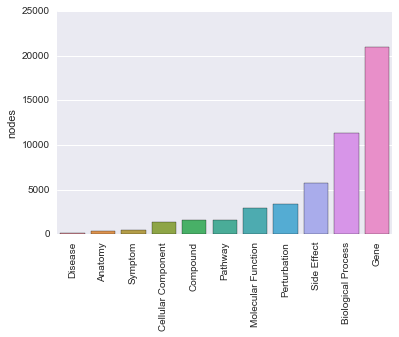

In [66]:
ax = seaborn.barplot(x='metanode', y='nodes', data=metanode_df.sort_values('nodes'))
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.set_xlabel(''); ax.set_ylabel('nodes');

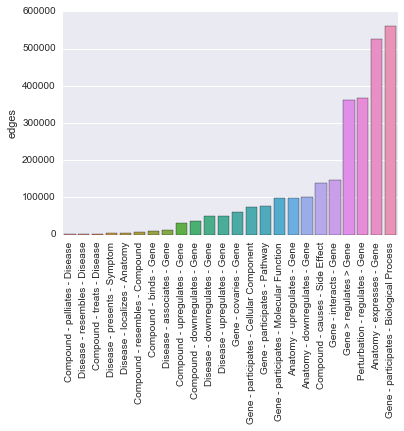

In [67]:
ax = seaborn.barplot(x='metaedge', y='edges', data=metaedge_df.sort_values('edges'))
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.set_xlabel(''); ax.set_ylabel('edges');